## Basic Libraries

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import re

## Data Reading & Extraction

In [2]:
def get_basic_df(data):
  new_list = []
  for i in range( len(data)):
    product_info = data[str(i) ]
    new_dict = dict()
    new_dict["id"] = str(i)
    n_vegetarian = 0
    n_vegan = 0
    for keys in product_info.keys():
      if keys in ["categories_hierarchy", "selling_countries", "packaging_materials"]:
        for v in product_info[keys]: # Get product info
          nc = (keys + "_"+ v).replace(":","_")
          new_dict[nc] = 1
      elif keys == "ingredient_origins": # ingredient_origins
        for sub_k in product_info[keys].keys():
          nc = (keys+"_" + sub_k).replace(":","_")
          new_dict[nc] = float(product_info[keys][sub_k])
      elif keys == "ingredients": # No of ingrs, vegan, veget
        if product_info[keys] != "unknown":
          ings = product_info[keys]
          new_dict["no_ingredients"] = len(ings)
          for ing in ings:
            try:
              if ing["vegan"] in ["yes", "maybe"]:
                n_vegan += 1
              if ing["vegetarian"] in ["yes", "maybe"]:
                n_vegetarian += 1
            except:
              None
        new_dict["no_vegan_ingredients"] = n_vegan
        new_dict["no_vegetarian_ingredients"] = n_vegetarian
      else: # Rest of columns
        new_dict[keys] = product_info[keys]


    new_list.append(new_dict)
  return pd.DataFrame(new_list)

In [3]:
# Reading train Data
f = open('/content/train_products.json')
data_train_json = json.load(f)

# Reading test Data
f = open('/content/test_products.json')
data_test_json = json.load(f)

In [4]:
len(data_train_json), len(data_test_json)

(20835, 1272)

In [5]:
df_train = get_basic_df(data_train_json)
df_test = get_basic_df(data_test_json)

In [6]:
df_train.shape, df_test.shape

((20835, 5183), (1272, 490))

In [7]:
df_train_copy = df_train.copy()
df_test_copy =  df_test.copy()

In [8]:
df_train = df_train_copy.copy()
df_test =  df_test_copy.copy()

## Data Cleansing

### Changing columns names

In [9]:
change_format_columns = lambda c: re.sub(" |%|:|-", "_", c)

In [10]:
df_train.columns = list(map(change_format_columns, df_train.columns ) )
df_test.columns = list(map(change_format_columns, df_test.columns) )

### Getting No. Categoties and No. Selling Countries

In [11]:
def get_no(df, name_cols):
  colums = [col for col in df.columns if name_cols in col]
  return df[colums].fillna(0).sum(axis=1)

df_train["no_categories"] = get_no(df_train, "categories_hierarchy")
df_train["no_selling_countries"] = get_no(df_train, "selling_countries")

df_test["no_categories"] = get_no(df_test, "categories_hierarchy")
df_test["no_selling_countries"] = get_no(df_test, "selling_countries")

## From str to numeric

In [12]:
columns = ["is_beverage", "additives_count", "calcium_100g", "carbohydrates_100g", "energy_kcal_100g", "fat_100g", "fiber_100g", "proteins_100g", "salt_100g", "sodium_100g", \
           "sugars_100g", "non_recyclable_and_non_biodegradable_materials_count", "est_co2_agriculture", "est_co2_consumption", "est_co2_distribution", "est_co2_packaging",\
           "est_co2_processing", "est_co2_transportation"]

In [13]:
for c in columns:
    df_train[c] = pd.to_numeric(df_train[c], errors='coerce')#.replace("unknown", np.nan)
    df_test[c] = pd.to_numeric(df_test[c], errors='coerce') #.replace("unknown", np.nan)

In [14]:
df_test["nutrition_grade"].replace(['a', 'b', 'c', 'd', 'e', 'unknown'], [1, .8, .6, .4, .2, np.nan], inplace=True)
df_train["nutrition_grade"].replace(['a', 'b', 'c', 'd', 'e', 'unknown'], [1, .8, .6, .4, .2, np.nan], inplace=True)


## Selecting Columns

In [15]:
selected_columns = ["nutrition_grade", "no_categories", "no_selling_countries", "no_vegan_ingredients", "no_vegetarian_ingredients", "no_ingredients"] + columns

In [59]:
X_train = df_train[selected_columns + ["ecoscore_grade"] ].copy()
y_train = df_train["ecoscore_grade"]
X_test = df_test[selected_columns].copy()
ids = df_test["id"]

In [24]:
y_train.unique(), ids.unique()

(array([2, 3, 4, 1, 0]),
 array(['0', '1', '2', ..., '1269', '1270', '1271'], dtype=object))

In [35]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20835 entries, 0 to 20834
Data columns (total 25 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   nutrition_grade                                       16913 non-null  float64
 1   no_categories                                         20835 non-null  float64
 2   no_selling_countries                                  20835 non-null  float64
 3   no_vegan_ingredients                                  20835 non-null  int64  
 4   no_vegetarian_ingredients                             20835 non-null  int64  
 5   no_ingredients                                        15681 non-null  float64
 6   is_beverage                                           20835 non-null  int64  
 7   additives_count                                       15681 non-null  float64
 8   calcium_100g                                          94

In [36]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1272 entries, 0 to 1271
Data columns (total 24 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   nutrition_grade                                       1072 non-null   float64
 1   no_categories                                         1272 non-null   float64
 2   no_selling_countries                                  1272 non-null   float64
 3   no_vegan_ingredients                                  1272 non-null   int64  
 4   no_vegetarian_ingredients                             1272 non-null   int64  
 5   no_ingredients                                        966 non-null    float64
 6   is_beverage                                           1272 non-null   int64  
 7   additives_count                                       966 non-null    float64
 8   calcium_100g                                          463 

## Data Viz

### Is imbalanced DF ?

In [30]:
y_train.value_counts()

1    6420
3    6089
2    3568
4    3238
0    1520
Name: ecoscore_grade, dtype: int64

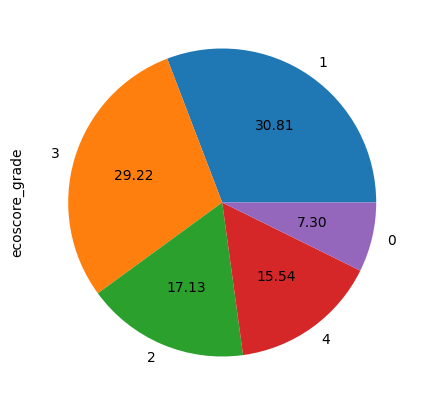

In [31]:
import seaborn as sns
fig = plt.figure(figsize=(5,5))
y_train.value_counts().plot.pie(autopct='%.2f')
plt.show()

### Under-sampling

In [39]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler()

In [60]:
X_under, y_under = undersample.fit_resample(X_train, y_train)
y_under.value_counts()

0    1520
1    1520
2    1520
3    1520
4    1520
Name: ecoscore_grade, dtype: int64

### EDA

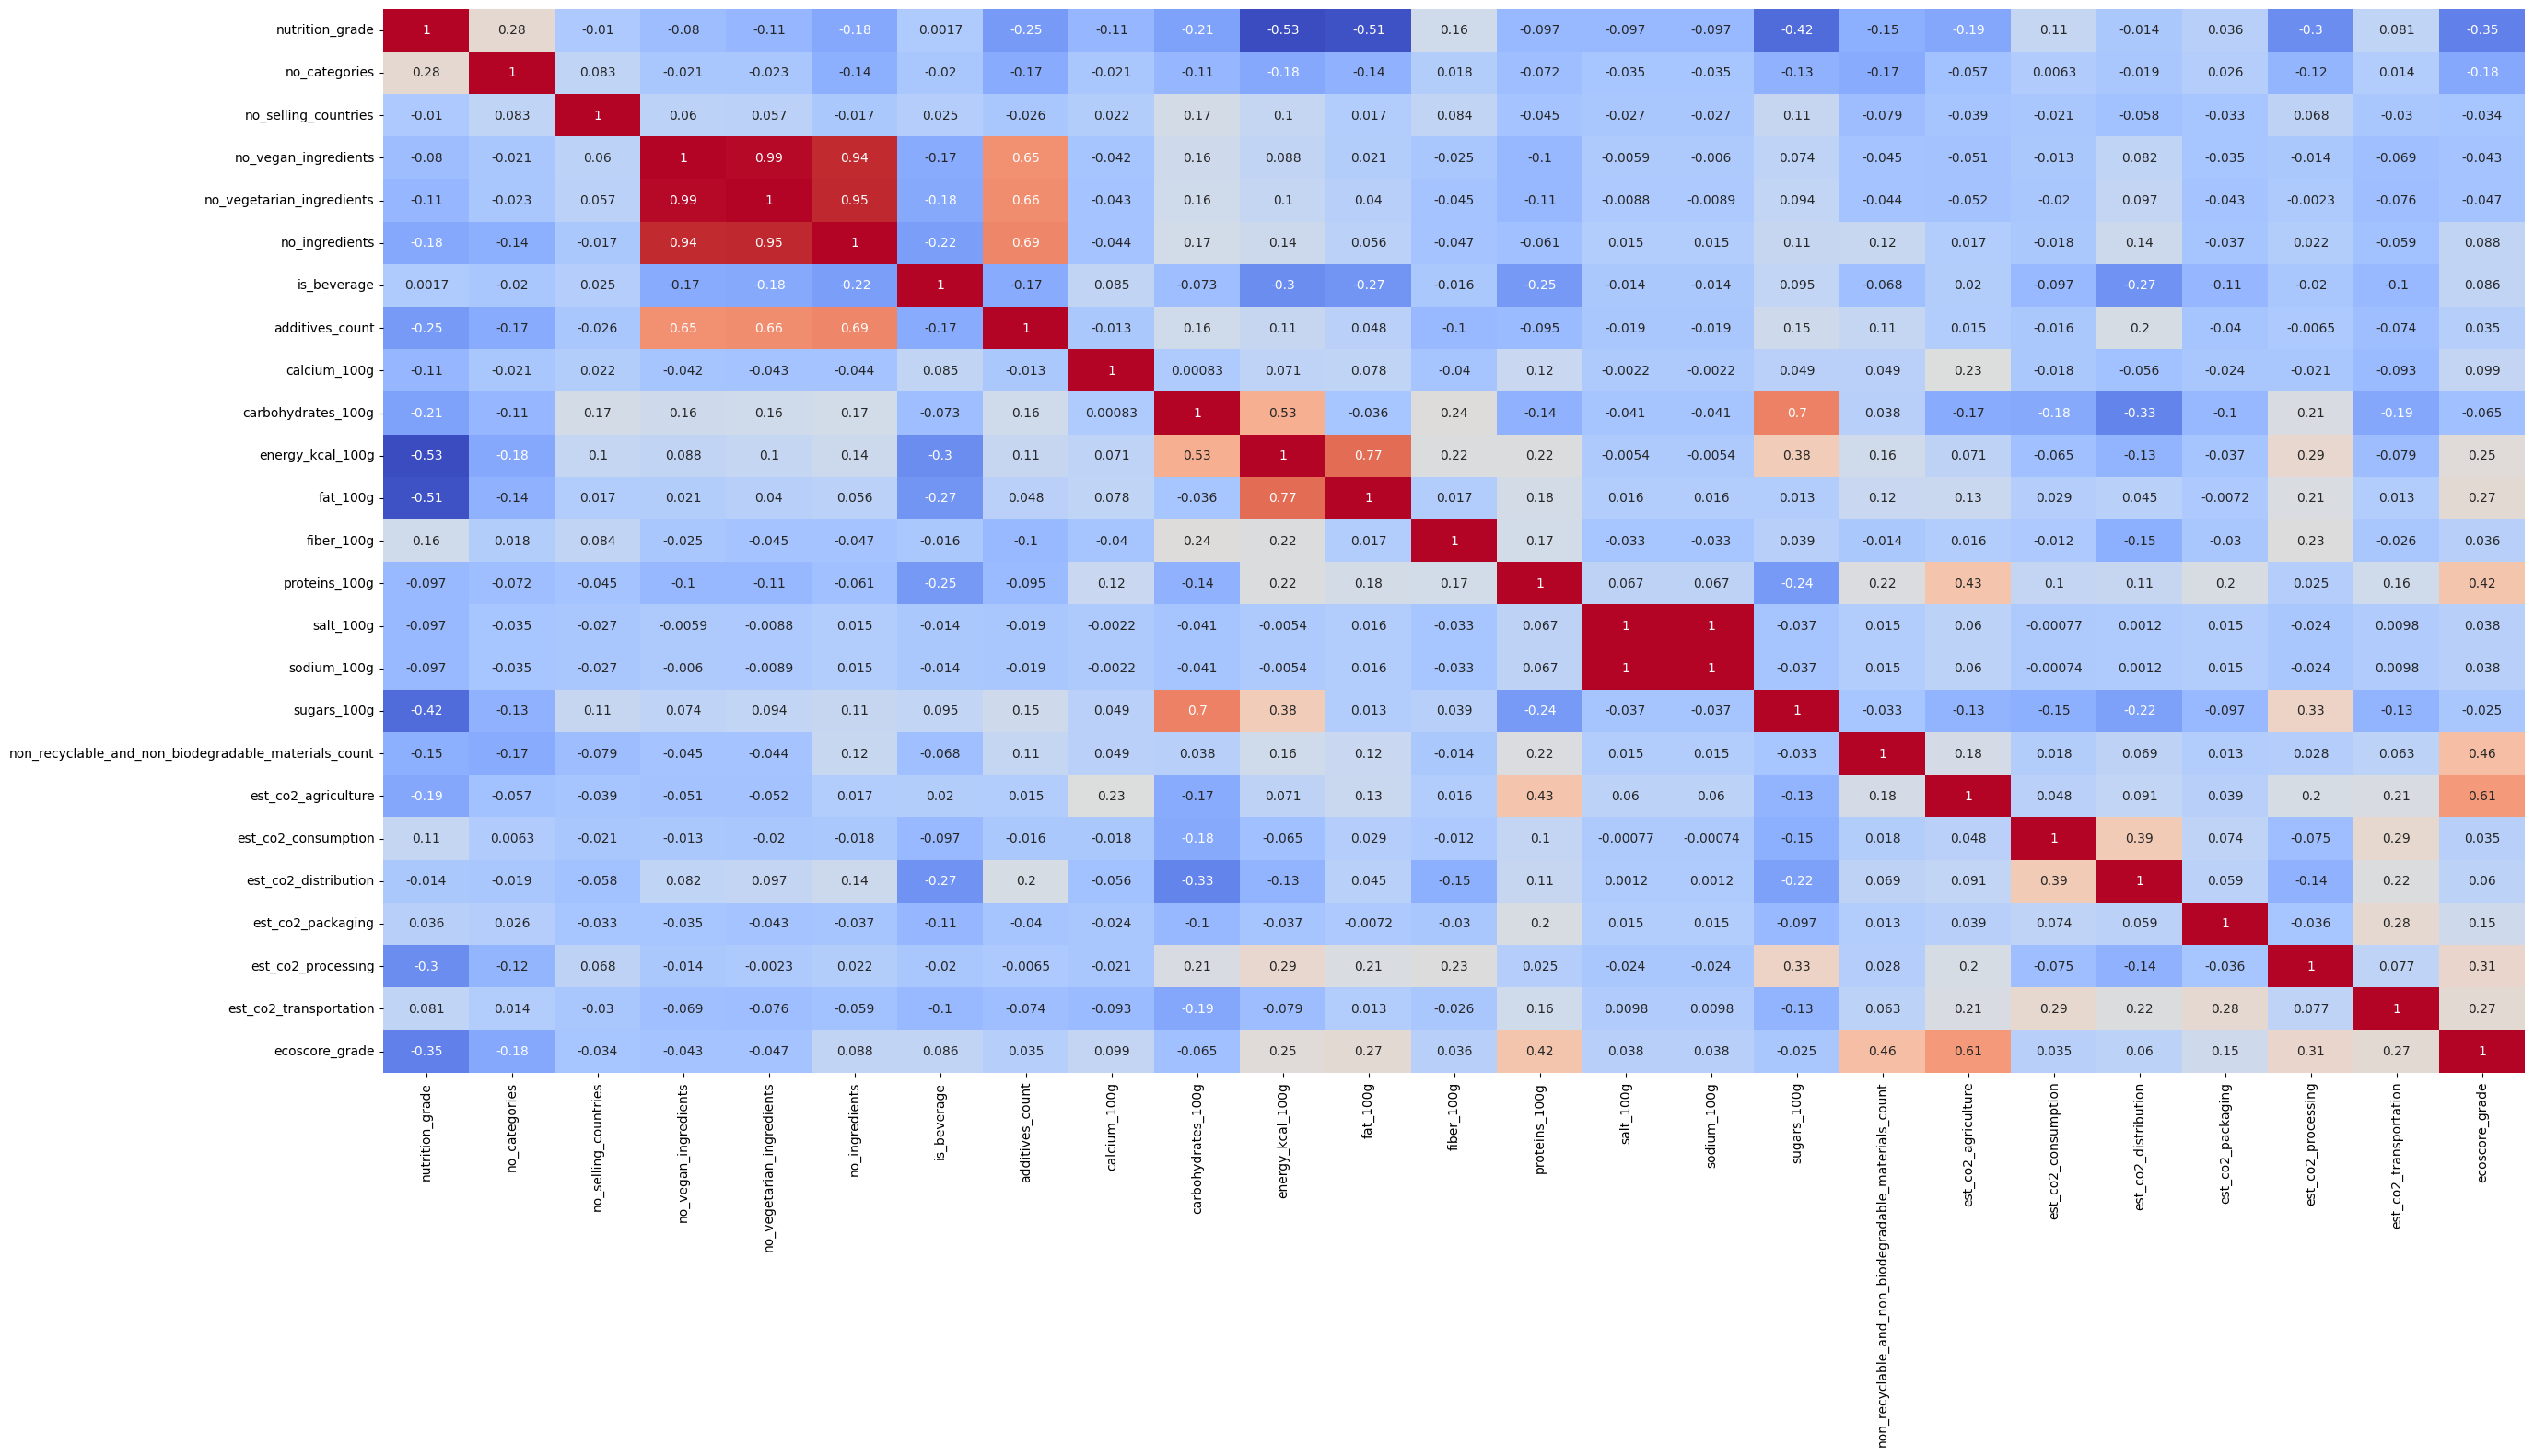

In [34]:
plt.figure(figsize=(30,15))
sns.heatmap(X_under.corr(), annot= True, cmap='coolwarm',cbar=False)
plt.show()

There are some features that have strong correlation with other features and since `calcium_100g` has much null values, we are going  to drop them.

In [61]:
drop_cols = ["no_vegan_ingredients", "no_vegetarian_ingredients", "energy_kcal_100g", "sugars_100g", "calcium_100g"]
X_under.drop(drop_cols, axis=1, inplace=True)
X_test.drop(drop_cols, axis=1, inplace=True)

In [62]:
X_under.drop(["ecoscore_grade"], axis=1, inplace=True)

In [63]:
X_under.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7600 entries, 0 to 7599
Data columns (total 19 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   nutrition_grade                                       6131 non-null   float64
 1   no_categories                                         7600 non-null   float64
 2   no_selling_countries                                  7600 non-null   float64
 3   no_ingredients                                        5954 non-null   float64
 4   is_beverage                                           7600 non-null   int64  
 5   additives_count                                       5954 non-null   float64
 6   carbohydrates_100g                                    6801 non-null   float64
 7   fat_100g                                              6773 non-null   float64
 8   fiber_100g                                            4995

In [44]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1272 entries, 0 to 1271
Data columns (total 19 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   nutrition_grade                                       1072 non-null   float64
 1   no_categories                                         1272 non-null   float64
 2   no_selling_countries                                  1272 non-null   float64
 3   no_ingredients                                        966 non-null    float64
 4   is_beverage                                           1272 non-null   int64  
 5   additives_count                                       966 non-null    float64
 6   carbohydrates_100g                                    1194 non-null   float64
 7   fat_100g                                              1198 non-null   float64
 8   fiber_100g                                            441 

## Imputing Missing Data

In [46]:
# X_under.drop(["calcium_100g"], axis=1, inplace=True)
# X_test.drop(["calcium_100g"], axis=1, inplace=True)

In [64]:
## nutrition grade
# X_under["nutrition_grade"].fillna(X_under["nutrition_grade"].median(), inplace = True)
# X_test["nutrition_grade"].fillna(X_test["nutrition_grade"].median(), inplace = True)

idx_im_cols = np.where((X_under.isnull().sum()/ X_under.shape[0]) > 0 )[0]
for i in idx_im_cols:
  # print(i)
  X_under.iloc[:, i].fillna(X_under.iloc[:, i].mean(), inplace = True)
  X_test.iloc[:, i].fillna(X_test.iloc[:, i].mean(), inplace = True)

In [65]:
X_under.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7600 entries, 0 to 7599
Data columns (total 19 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   nutrition_grade                                       7600 non-null   float64
 1   no_categories                                         7600 non-null   float64
 2   no_selling_countries                                  7600 non-null   float64
 3   no_ingredients                                        7600 non-null   float64
 4   is_beverage                                           7600 non-null   int64  
 5   additives_count                                       7600 non-null   float64
 6   carbohydrates_100g                                    7600 non-null   float64
 7   fat_100g                                              7600 non-null   float64
 8   fiber_100g                                            7600

In [66]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1272 entries, 0 to 1271
Data columns (total 19 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   nutrition_grade                                       1272 non-null   float64
 1   no_categories                                         1272 non-null   float64
 2   no_selling_countries                                  1272 non-null   float64
 3   no_ingredients                                        1272 non-null   float64
 4   is_beverage                                           1272 non-null   int64  
 5   additives_count                                       1272 non-null   float64
 6   carbohydrates_100g                                    1272 non-null   float64
 7   fat_100g                                              1272 non-null   float64
 8   fiber_100g                                            1272

##  Data Scaling

In [67]:
from sklearn.preprocessing import StandardScaler
st_x = StandardScaler()
X_under = st_x.fit_transform(X_under)
X_test = st_x.transform(X_test)

## Model LogisticRegression

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, ConfusionMatrixDisplay, classification_report

def logistic_model(C_,solver_ , multiclass_):
    logistic_regression_model = LogisticRegression(random_state=42, solver= solver_, multi_class= multiclass_, n_jobs=-1, C=C_ , max_iter=500)
    return logistic_regression_model

In [69]:
model = logistic_model(1,'newton-cg','multinomial')
model.fit(X_under, y_under)
logistic_r_predictions = model.predict(X_test)
# print(confusion_matrix(y_test,predictions))
# print(accuracy_score(y_test,predictions))

## Predictions

In [168]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

In [71]:
predictions_json = dict()
predictions_json["target"] = {}

In [72]:
for i,p in zip(ids, logistic_r_predictions):
  # print(i,p)
  predictions_json["target"][str(i)] = p

In [73]:
# Your codes ....
json.dumps(predictions_json, cls=NpEncoder)

'{"target": {"0": 1, "1": 2, "2": 1, "3": 1, "4": 2, "5": 0, "6": 1, "7": 2, "8": 1, "9": 1, "10": 1, "11": 0, "12": 1, "13": 1, "14": 2, "15": 1, "16": 0, "17": 0, "18": 1, "19": 1, "20": 1, "21": 3, "22": 1, "23": 2, "24": 1, "25": 1, "26": 1, "27": 1, "28": 1, "29": 1, "30": 1, "31": 1, "32": 1, "33": 3, "34": 1, "35": 4, "36": 1, "37": 1, "38": 0, "39": 1, "40": 3, "41": 1, "42": 1, "43": 0, "44": 1, "45": 0, "46": 0, "47": 1, "48": 0, "49": 3, "50": 1, "51": 1, "52": 3, "53": 1, "54": 4, "55": 1, "56": 1, "57": 1, "58": 2, "59": 4, "60": 4, "61": 1, "62": 0, "63": 1, "64": 1, "65": 0, "66": 1, "67": 1, "68": 1, "69": 1, "70": 0, "71": 1, "72": 1, "73": 1, "74": 4, "75": 1, "76": 1, "77": 4, "78": 1, "79": 0, "80": 1, "81": 1, "82": 4, "83": 1, "84": 3, "85": 4, "86": 1, "87": 1, "88": 2, "89": 1, "90": 4, "91": 1, "92": 2, "93": 1, "94": 1, "95": 1, "96": 1, "97": 1, "98": 2, "99": 0, "100": 1, "101": 1, "102": 1, "103": 1, "104": 1, "105": 0, "106": 0, "107": 1, "108": 1, "109": 

## Another Trainig


In [136]:
selected_columns = ["nutrition_grade", "no_categories", "no_selling_countries", "no_vegan_ingredients", "no_vegetarian_ingredients", "no_ingredients"] + columns

In [137]:
X_train = df_train[selected_columns + ["ecoscore_grade"] ].copy()
y_train = df_train["ecoscore_grade"]
X_test = df_test[selected_columns].copy()
ids = df_test["id"]

In [138]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20835 entries, 0 to 20834
Data columns (total 25 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   nutrition_grade                                       16913 non-null  float64
 1   no_categories                                         20835 non-null  float64
 2   no_selling_countries                                  20835 non-null  float64
 3   no_vegan_ingredients                                  20835 non-null  int64  
 4   no_vegetarian_ingredients                             20835 non-null  int64  
 5   no_ingredients                                        15681 non-null  float64
 6   is_beverage                                           20835 non-null  int64  
 7   additives_count                                       15681 non-null  float64
 8   calcium_100g                                          94

In [139]:
## Dropping Columns
drop_cols = ["no_vegan_ingredients", "no_vegetarian_ingredients", "energy_kcal_100g", "sugars_100g", "calcium_100g", "fiber_100g"]
X_train.drop(drop_cols, axis=1, inplace=True)
X_test.drop(drop_cols, axis=1, inplace=True)
X_train.drop(["ecoscore_grade"], axis=1, inplace=True)

In [140]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20835 entries, 0 to 20834
Data columns (total 18 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   nutrition_grade                                       16913 non-null  float64
 1   no_categories                                         20835 non-null  float64
 2   no_selling_countries                                  20835 non-null  float64
 3   no_ingredients                                        15681 non-null  float64
 4   is_beverage                                           20835 non-null  int64  
 5   additives_count                                       15681 non-null  float64
 6   carbohydrates_100g                                    18558 non-null  float64
 7   fat_100g                                              18500 non-null  float64
 8   proteins_100g                                         18

In [141]:
## nutrition grade
X_train["nutrition_grade"].fillna(X_train["nutrition_grade"].median(), inplace = True)
X_test["nutrition_grade"].fillna(X_test["nutrition_grade"].median(), inplace = True)


idx_im_cols = np.where((X_train.isnull().sum()/ X_train.shape[0]) > 0 )[0]
for i in idx_im_cols:
  # print(i)
  X_train.iloc[:, i].fillna(X_train.iloc[:, i].mean(), inplace = True)
  X_test.iloc[:, i].fillna(X_test.iloc[:, i].mean(), inplace = True)

In [142]:
y_train.value_counts()

1    6420
3    6089
2    3568
4    3238
0    1520
Name: ecoscore_grade, dtype: int64

In [124]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler()
smt = SMOTE(random_state=42) #over-sampling
smen = SMOTEENN(random_state=42) # combination of under-over sampling

In [143]:
# X_over, y_over = smen.fit_resample(X_train, y_train)
# y_over.value_counts()

X_over, y_over = undersample.fit_resample(X_train, y_train)
y_over.value_counts()

0    1520
1    1520
2    1520
3    1520
4    1520
Name: ecoscore_grade, dtype: int64

In [144]:
from sklearn.preprocessing import StandardScaler
st_x = StandardScaler()
X_over = st_x.fit_transform(X_over)
X_test = st_x.transform(X_test)

## Applying PCA

In [145]:
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import PCA

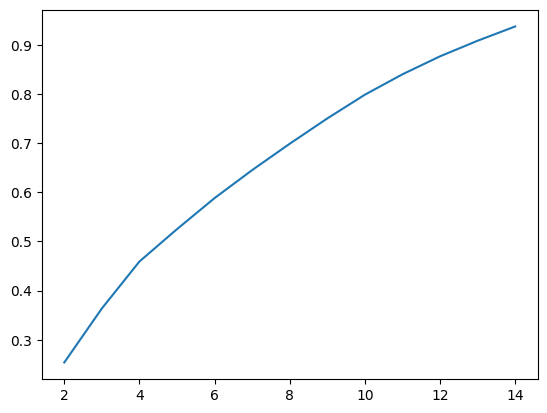

In [146]:
pca_data = {'explained_variance': [],
                'n_components': []}

for n in range(2, 15):
    pca = PCA(n_components=n)
    pca.fit(X_over)

    pca_data['explained_variance'].append(sum(pca.explained_variance_ratio_))
    pca_data['n_components'].append(n)
    # print("\n for n components= ")
    # print(n)
    # print( pca.explained_variance_ratio_, sum(pca.explained_variance_ratio_)

plt.plot( pca_data['n_components'],  pca_data['explained_variance'])
plt.show()

In [112]:
# # KPCA
# kpca = KernelPCA(n_components=10, kernel='rbf')
# kpca.fit(X_over)

# # Configuramos los datos de entrenamiento con PCA
# X_over = kpca.transform(X_over)
# X_test = kpca.transform(X_test)

In [147]:
# PCA
pca= PCA(n_components=10)
pca.fit(X_over)

# Configuramos los datos de entrenamiento con PCA
X_over = pca.transform(X_over)
X_test = pca.transform(X_test)

In [148]:
model = logistic_model(1,'newton-cg','multinomial')
model.fit(X_over, y_over)
logistic_r_predictions = model.predict(X_test)

In [149]:
predictions_json = dict()
predictions_json["target"] = {}

In [150]:
for i,p in zip(ids, logistic_r_predictions):
  # print(i,p)
  predictions_json["target"][str(i)] = p

In [151]:
# Your codes ....
json.dumps(predictions_json, cls=NpEncoder)

'{"target": {"0": 1, "1": 2, "2": 1, "3": 1, "4": 2, "5": 0, "6": 1, "7": 2, "8": 1, "9": 1, "10": 1, "11": 0, "12": 1, "13": 1, "14": 0, "15": 1, "16": 0, "17": 0, "18": 1, "19": 1, "20": 1, "21": 3, "22": 1, "23": 4, "24": 1, "25": 1, "26": 1, "27": 1, "28": 1, "29": 1, "30": 2, "31": 2, "32": 1, "33": 2, "34": 1, "35": 2, "36": 1, "37": 1, "38": 0, "39": 1, "40": 3, "41": 1, "42": 1, "43": 0, "44": 1, "45": 0, "46": 0, "47": 1, "48": 0, "49": 4, "50": 1, "51": 1, "52": 4, "53": 1, "54": 2, "55": 1, "56": 1, "57": 0, "58": 2, "59": 4, "60": 4, "61": 1, "62": 0, "63": 1, "64": 1, "65": 0, "66": 1, "67": 1, "68": 1, "69": 1, "70": 0, "71": 1, "72": 1, "73": 1, "74": 2, "75": 1, "76": 1, "77": 2, "78": 1, "79": 0, "80": 2, "81": 1, "82": 4, "83": 1, "84": 3, "85": 2, "86": 1, "87": 1, "88": 2, "89": 1, "90": 2, "91": 1, "92": 2, "93": 1, "94": 1, "95": 1, "96": 1, "97": 2, "98": 2, "99": 0, "100": 1, "101": 1, "102": 1, "103": 1, "104": 1, "105": 0, "106": 0, "107": 1, "108": 2, "109": 

## Cross Validation

In [306]:
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score
import warnings
import seaborn as sns
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")

In [307]:
selected_columns = ["nutrition_grade", "no_categories", "no_selling_countries", "no_vegan_ingredients", "no_vegetarian_ingredients", "no_ingredients"] + columns

In [313]:
X_train = df_train[selected_columns + ["ecoscore_grade"] ].copy()
# y_train = df_train["ecoscore_grade"]
X_test = df_test[selected_columns].copy()
ids = df_test["id"]
# X_train.drop(["ecoscore_grade"], axis=1, inplace=True)

In [309]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20835 entries, 0 to 20834
Data columns (total 25 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   nutrition_grade                                       16913 non-null  float64
 1   no_categories                                         20835 non-null  float64
 2   no_selling_countries                                  20835 non-null  float64
 3   no_vegan_ingredients                                  20835 non-null  int64  
 4   no_vegetarian_ingredients                             20835 non-null  int64  
 5   no_ingredients                                        15681 non-null  float64
 6   is_beverage                                           20835 non-null  int64  
 7   additives_count                                       15681 non-null  float64
 8   calcium_100g                                          94

### Dropping Calcium

In [314]:
## Dropping columns
drop_cols = ["calcium_100g"]
X_train.drop(drop_cols, axis=1, inplace=True)
X_test.drop(drop_cols, axis=1, inplace=True)

In [311]:
# X_train.dropna(inplace=True)

In [312]:
# X_train = X_train.reset_index()
# X_train.drop(["index"], axis=1, inplace=True)
# y_train = X_train["ecoscore_grade"]
# X_train.drop(["ecoscore_grade"], axis=1, inplace=True)

### Imputing missing Data


In [315]:
idx_im_cols = np.where((X_train.isnull().sum()/ X_train.shape[0]) > 0 )[0]
for i in idx_im_cols:
  # print(i)
  X_train.iloc[:, i].fillna(X_train.iloc[:, i].median(), inplace = True)
  X_test.iloc[:, i].fillna(X_test.iloc[:, i].median(), inplace = True)

### Applying variance_inflation_factor Test

In [316]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [317]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler()

In [318]:
X_under, y_under = undersample.fit_resample(X_train, df_train["ecoscore_grade"])
y_under.value_counts()

0    1520
1    1520
2    1520
3    1520
4    1520
Name: ecoscore_grade, dtype: int64

In [319]:
st_x = StandardScaler()

df_scaled = st_x.fit_transform(X_under)
cols = [cname for cname in X_under.columns if X_under[cname].dtype in ['int64', 'float64']]
df_scaled = pd.DataFrame(df_scaled, columns=cols)
# df_scaled.head()

In [320]:
X_data = pd.DataFrame()
X_data['Feature'] = X_train.columns

X_data['VIF']= [variance_inflation_factor(df_scaled.values, i) for i in range(len(X_under.columns))]
print(X_data)
print(list(X_data['Feature']))

                                              Feature            VIF
0                                     nutrition_grade       1.941387
1                                       no_categories       1.155820
2                                no_selling_countries       1.061201
3                                no_vegan_ingredients      49.416054
4                           no_vegetarian_ingredients      52.053519
5                                      no_ingredients       5.811238
6                                         is_beverage       1.512175
7                                     additives_count       2.079776
8                                  carbohydrates_100g       3.782460
9                                    energy_kcal_100g       4.813901
10                                           fat_100g       3.843748
11                                         fiber_100g       1.248130
12                                      proteins_100g       1.638109
13                                

The VIF value must be beween 1 and 5, let´s remove columns with values higher than 5.

In [321]:
X_vif = df_scaled.drop(["no_vegan_ingredients", "no_vegetarian_ingredients", "energy_kcal_100g", "salt_100g"], axis = 1)

In [322]:
X_data = pd.DataFrame()
X_data['Feature'] = X_vif.columns

X_data['VIF']= [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]
print(X_data)

                                              Feature       VIF
0                                     nutrition_grade  1.918367
1                                       no_categories  1.129090
2                                no_selling_countries  1.049943
3                                      no_ingredients  1.966153
4                                         is_beverage  1.510524
5                                     additives_count  2.019471
6                                  carbohydrates_100g  2.549360
7                                            fat_100g  1.574349
8                                          fiber_100g  1.234463
9                                       proteins_100g  1.544697
10                                        sodium_100g  1.009374
11                                        sugars_100g  2.545831
12  non_recyclable_and_non_biodegradable_materials...  1.384453
13                                est_co2_agriculture  1.813483
14                                est_co

#### Dropping Columns on X_train & X_Test

In [323]:
## Dropping columns
drop_cols = ["no_vegan_ingredients", "no_vegetarian_ingredients", "energy_kcal_100g", "salt_100g"]#, "sugars_100g"]
X_train.drop(drop_cols, axis=1, inplace=True)
X_test.drop(drop_cols, axis=1, inplace=True)

In [324]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20835 entries, 0 to 20834
Data columns (total 20 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   nutrition_grade                                       20835 non-null  float64
 1   no_categories                                         20835 non-null  float64
 2   no_selling_countries                                  20835 non-null  float64
 3   no_ingredients                                        20835 non-null  float64
 4   is_beverage                                           20835 non-null  int64  
 5   additives_count                                       20835 non-null  float64
 6   carbohydrates_100g                                    20835 non-null  float64
 7   fat_100g                                              20835 non-null  float64
 8   fiber_100g                                            20

### Outliers

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20]),
 [Text(1, 0, 'nutrition_grade'),
  Text(2, 0, 'no_categories'),
  Text(3, 0, 'no_selling_countries'),
  Text(4, 0, 'no_ingredients'),
  Text(5, 0, 'is_beverage'),
  Text(6, 0, 'additives_count'),
  Text(7, 0, 'carbohydrates_100g'),
  Text(8, 0, 'fat_100g'),
  Text(9, 0, 'fiber_100g'),
  Text(10, 0, 'proteins_100g'),
  Text(11, 0, 'sodium_100g'),
  Text(12, 0, 'sugars_100g'),
  Text(13, 0, 'non_recyclable_and_non_biodegradable_materials_count'),
  Text(14, 0, 'est_co2_agriculture'),
  Text(15, 0, 'est_co2_consumption'),
  Text(16, 0, 'est_co2_distribution'),
  Text(17, 0, 'est_co2_packaging'),
  Text(18, 0, 'est_co2_processing'),
  Text(19, 0, 'est_co2_transportation'),
  Text(20, 0, 'ecoscore_grade')])

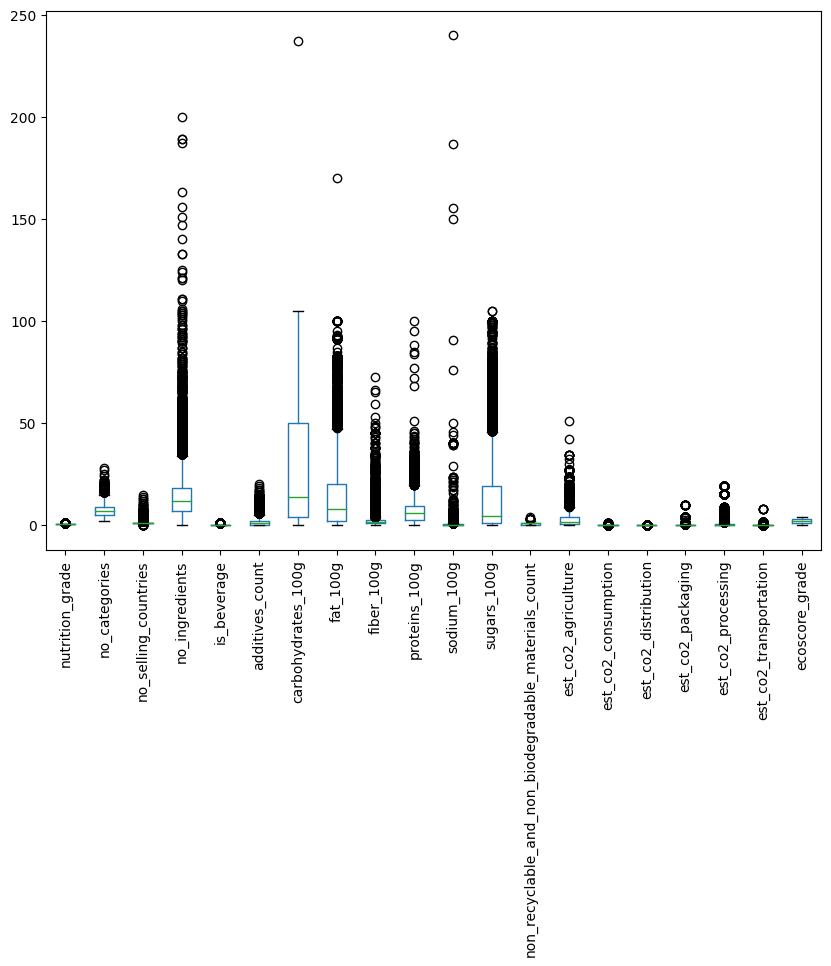

In [325]:
#Outliers
num_features = X_train #pd.DataFrame(X_train)
# num_features

plt.figure(figsize=(10,7))
num_features.boxplot(grid=False)
plt.xticks(rotation=90)

In [300]:
def dropping_outliers(df):
  for c in df.columns:
    # q3, q1 = np.percentile(df[c], [75 ,25] )
    # iqr = q3 - q1
    # aux_bool = (df[c] < (q1 - 1.5 * iqr)) |  (df[c] > (q3 + 1.5 * iqr))
    aux_bool = df[c] <= 100
    df = df.loc[aux_bool,:]
  return df

In [326]:
X_train_no_out = dropping_outliers(X_train.copy())

In [327]:
X_train_no_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20799 entries, 0 to 20834
Data columns (total 20 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   nutrition_grade                                       20799 non-null  float64
 1   no_categories                                         20799 non-null  float64
 2   no_selling_countries                                  20799 non-null  float64
 3   no_ingredients                                        20799 non-null  float64
 4   is_beverage                                           20799 non-null  int64  
 5   additives_count                                       20799 non-null  float64
 6   carbohydrates_100g                                    20799 non-null  float64
 7   fat_100g                                              20799 non-null  float64
 8   fiber_100g                                            20

In [328]:
X_train = X_train_no_out.reset_index().copy()
X_train.drop(["index"], axis=1, inplace=True)
y_train = X_train["ecoscore_grade"]
X_train.drop(["ecoscore_grade"], axis=1, inplace=True)

### Trying some folds with different Algorithms

In [329]:
LR=LogisticRegression()
LSVC=LinearSVC()
SVM=SVC()
modelos=["LogisticRegression"]*4+["LinearSVC"]*4+["SVC"]*4
metricas=["accuracy","f1","precision","recall"]*3

def folds(n, X, y):
    kf = KFold(n_splits=n, shuffle=True)
    p={"Modelo":modelos*n,"Metric":metricas*n,"Value":[]}

    for train_index, test_index in kf.split(X):
      X_train, X_test = X.iloc[train_index, :].copy(), X.iloc[test_index, : ].copy()
      y_train, y_test = y[train_index], y[test_index]

      # Scaling
      st_x = StandardScaler()
      X_train = st_x.fit_transform(X_train)
      X_test = st_x.transform(X_test)

      #training
      LR.fit(X_train,y_train)
      LSVC.fit(X_train,y_train)
      SVM.fit(X_train,y_train)

      #predict
      LR_Predict=LR.predict(X_test)
      LSVC_Predict=LSVC.predict(X_test)
      SVM_Predict=SVM.predict(X_test)
      for y_pred in (LR_Predict,LSVC_Predict,SVM_Predict):
          p["Value"].append( accuracy_score(y_test, y_pred))
          p["Value"].append( f1_score(y_test, y_pred, average="macro"))
          p["Value"].append( precision_score(y_test, y_pred, average="macro"))
          p["Value"].append( recall_score(y_test, y_pred, average="macro"))

    return p

5 folds

In [342]:
# X_train.info()
# spike_cols = [col for col in X_train.columns if 'spike' in col]
# X_train.iloc[:,12:].info()

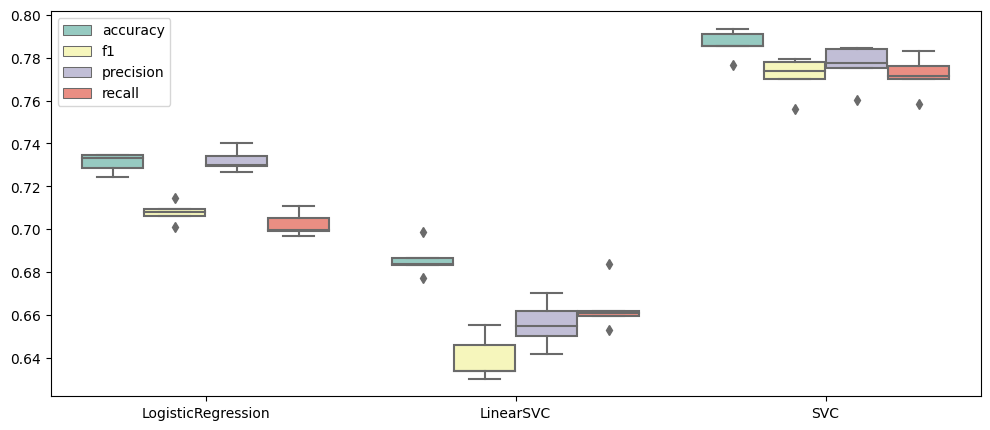

In [334]:
X_folds = X_train.copy(deep=True)
performance = folds(5, X_folds, y_train)
ax = plt.subplots(figsize=(12, 5))
ax = sns.boxplot(x="Modelo", y="Value", hue="Metric",data=performance, palette="Set3")

It seams that model SVC is the best model among Log Reg and LinearSVC, now we are going use RandomizedSearchCV to set different parameters to the model and fit the best to predict.

### Prediction

In [338]:
from sklearn.model_selection import RandomizedSearchCV
svm=SVC()
params = {
    'C' : np.array(range(1,11,2)) / 10,
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree' : list(range(2,5,1) ),
    'gamma' : ['scale', 'auto']
}

In [339]:
# Scaling
st_x = StandardScaler()
X_train = st_x.fit_transform(X_train)
X_test = st_x.transform(X_test)

In [340]:
X_train.shape, len(y_train)

((20799, 19), 20799)

In [341]:
rand_est = RandomizedSearchCV(svm, params , n_iter = 10, cv=5, scoring='f1_macro').fit(X_train, y_train)

In [343]:
print(rand_est.best_estimator_)
print(rand_est.best_params_)
# print(rand_est.predict(X.loc[[0]]))

SVC(C=0.9, degree=4, gamma='auto')
{'kernel': 'rbf', 'gamma': 'auto', 'degree': 4, 'C': 0.9}


In [344]:
svc_predictions = rand_est.predict(X_test)

In [345]:
predictions_json = dict()
predictions_json["target"] = {}

In [346]:
for i,p in zip(ids, svc_predictions):
  # print(i,p)
  predictions_json["target"][str(i)] = p

In [347]:
# Prediction
json.dumps(predictions_json, cls=NpEncoder)

'{"target": {"0": 1, "1": 2, "2": 1, "3": 1, "4": 4, "5": 1, "6": 1, "7": 3, "8": 1, "9": 1, "10": 1, "11": 1, "12": 1, "13": 1, "14": 3, "15": 1, "16": 1, "17": 0, "18": 1, "19": 1, "20": 1, "21": 3, "22": 1, "23": 3, "24": 1, "25": 1, "26": 1, "27": 1, "28": 1, "29": 1, "30": 1, "31": 1, "32": 1, "33": 3, "34": 1, "35": 2, "36": 1, "37": 1, "38": 1, "39": 1, "40": 3, "41": 1, "42": 1, "43": 0, "44": 1, "45": 1, "46": 1, "47": 1, "48": 1, "49": 3, "50": 1, "51": 1, "52": 3, "53": 1, "54": 4, "55": 1, "56": 1, "57": 1, "58": 4, "59": 4, "60": 4, "61": 1, "62": 1, "63": 1, "64": 1, "65": 0, "66": 1, "67": 1, "68": 1, "69": 1, "70": 1, "71": 1, "72": 1, "73": 1, "74": 4, "75": 1, "76": 1, "77": 4, "78": 1, "79": 1, "80": 1, "81": 1, "82": 4, "83": 1, "84": 3, "85": 3, "86": 1, "87": 1, "88": 4, "89": 1, "90": 4, "91": 1, "92": 3, "93": 1, "94": 1, "95": 1, "96": 1, "97": 1, "98": 3, "99": 0, "100": 1, "101": 1, "102": 1, "103": 1, "104": 1, "105": 0, "106": 0, "107": 1, "108": 1, "109": 

After some tests, the best config was:

SVC(degree=2)
{'kernel': 'rbf', 'gamma': 'scale', 'degree': 2}

on platform showed:

Your F1-score is...
0.675305590867915